In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import Window

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from functools import reduce

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200606123645-0000
KERNEL_ID = 3c1f045a-12a6-4477-ab5a-ea9e7858a05a


In [2]:
# Libraries for machine learning
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier,GBTClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel as mlm

In [3]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.ap-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-73e1d99e-8b6b-4f21-b43f-885ffe67d837',
    'iam_service_endpoint': 'https://iam.au-syd.bluemix.net/oidc/token',
    'api_key': 'TosvaS2BHiBtPV5uD02xUsCZQK5EvbCw7Hmx1_imt3_y'
}

configuration_name = 'os_bad668139d074f7c86ead86dd6169f7c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify2-donotdelete-pr-787ueasvdg2on1'))
# df_data_1.take(5)


In [4]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify2-donotdelete-pr-787ueasvdg2on1'))
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# 1. Clean Dataset
Clean data before data exploration by removing the data without userId

In [5]:
df = df.filter(df.userId != "")
# df.count()

# 2. Data Exploration

### 2-1 Define Churn 
Check what kind of the pages the data has

In [6]:
### See different pages
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Define churn happened when the "Cancellation Confirmation" page is visited 

In [7]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df_withchurn = df.withColumn("churn", Fsum("churn").over(windowval))

In [8]:
churn_users = df_withchurn.select('userId', 'churn').dropDuplicates()
# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    1|
|200002|    1|
|   296|    1|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|200037|    1|
|   169|    0|
|   205|    0|
+------+-----+
only showing top 10 rows



In [9]:
# Again define pandas df for better view
dfp = df_withchurn.toPandas()
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
422403,Mobb Deep,Logged In,Greyson,M,44,Reid,257.51465,paid,"Fort Madison-Keokuk, IA-IL-MO",PUT,NextSong,1530446571000,2814,Drop A Gem On 'Em,200,1541603189000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",289,0
493322,Michael BublÃÂ©,Logged In,Kendal,F,1,Morgan,225.90649,paid,"Cincinnati, OH-KY-IN",PUT,NextSong,1536464866000,1369,Home (Album Version),200,1539285735000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",264,0
350703,Jarabe De Palo,Logged In,Erick,M,158,Brooks,255.73832,paid,"Selma, AL",PUT,NextSong,1537956751000,2987,Agua,200,1541284992000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",58,0
411563,Get-far,Logged In,Giovanni,M,268,Williams,457.42975,paid,"Valdosta, GA",PUT,NextSong,1537783163000,3456,Shining Star (Pornocult Vocal Mix),200,1542022732000,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,299,0
345251,Lil Boosie feat. Webbie,Logged In,Jaxon,M,43,Reilly,276.08771,paid,"Jacksonville, FL",PUT,NextSong,1531760527000,2406,Smoking On Purple (feat. Webbie) (amended albu...,200,1540572047000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,86,0
273003,Base Ball Bear,Logged In,Jose,M,112,Martin,255.60771,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1535800493000,477,Sayonara-Nostalgia,200,1540731791000,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,300031,0
228793,None,Logged In,Troy,M,25,Mathis,NaN,paid,"San Francisco-Oakland-Hayward, CA",PUT,Logout,1537376437000,286,None,307,1540747356000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100009,0
345341,Nirvana,Logged In,Jaxon,M,62,Reilly,260.98893,paid,"Jacksonville, FL",PUT,NextSong,1531760527000,2627,The Man Who Sold The World,200,1541650747000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,86,0
151135,Eminem,Logged In,Adriel,M,103,Mendoza,265.40363,free,"Kansas City, MO-KS",PUT,NextSong,1535623466000,1926,As The World Turns,200,1540046498000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18,1
471244,Madeleine Peyroux,Logged In,Nikolas,M,249,Olsen,156.10730,paid,"Oxnard-Thousand Oaks-Ventura, CA",PUT,NextSong,1528403713000,3692,A Prayer (LP Version),200,1542138936000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121,0


### 2-2 Data Exploration (with churn column)

Define a function to plot distribution 

In [10]:
dfp = df_withchurn.toPandas()
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);    

#### Gender distribution

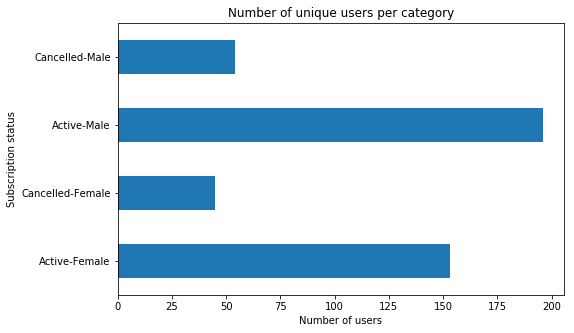

In [11]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

In general, it doesn't look much difference in the gender distribution for both churn and no-churn

#### The difference in levels when churned and not-churned

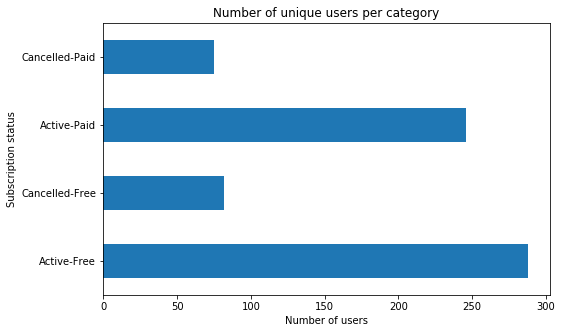

In [12]:
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

#### Page Visit Occurence (%) for Active and Cancelled Users 

In [ ]:
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of event occurence (%)')
ax.set_title('Percent of event occurence for active and cancelled users');

#### Distribution by Time

In [14]:
get_hour = udf(lambda x: datetime.datetime
               .fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", 
                                       get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime
                  .fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", 
                                       get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime
              .fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", 
                                       get_day(df_withchurn.ts))

get_month = udf(lambda x: datetime.datetime
              .fromtimestamp(x / 1000.0).month)
df_withchurn = df_withchurn.withColumn("month", 
                                       get_month(df_withchurn.ts))

def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')

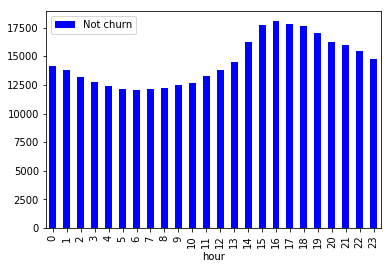

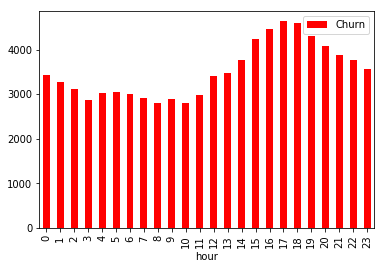

In [15]:
plot_cnt_by_churn("hour")

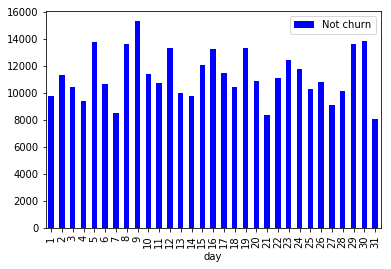

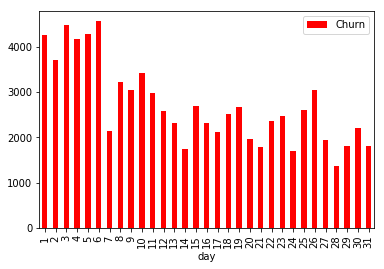

In [16]:
plot_cnt_by_churn("day")

# 3. Feature Engineering

I am going to keep features as follow

1. Categorial Features
    1. Gender of Users 


2. Numerial Features
    1. Song length per user per session
    - Frequency of each page visit excluding Cancel and Cancel Confirmation
    - Number of songs per session
    - Session's duration
    - The user's subscription age
    - Number of days as a paid user
    - Percent of the free/paid songs per user

### 3-1. Categorial Features

#### A. Gender column
For Gender column, as there are only 2 possible variables M and F, I'll define M as 1 and F as 0

In [17]:
dfp['gender'].unique()

array(['F', 'M'], dtype=object)

In [18]:
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df_withchurn.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})
print((gender_df.count(),len(gender_df.columns)))

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|   234|     1|
|   188|     0|
|    44|     0|
+------+------+
only showing top 3 rows

None None
(448, 2)


### 3-2. Numerical Features
#### A. Song length per user per session

In [8]:
song_length = df_withchurn.filter(df_withchurn.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
# song_length.toPandas().head(10)
song_length.show(3)

+------+------------------+-------------------+
|userId|        mean_hours|        stdev_hours|
+------+------------------+-------------------+
|200002|4.3719903800000015|  2.886952090547904|
|100010|3.5931876027777774|0.30956955746629133|
|   296|1.5730083366666665|  1.357669534545077|
+------+------------------+-------------------+
only showing top 3 rows



#### B. Frequency of each page visit excluding Cancel and Cancel Confirmation 

Get how often each user visits each page

In [10]:
# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df_withchurn.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.254453,0.508906,1.526718,0.763359,0.000000,0.254453,5.852417,2.798982,78.880407,2.798982,0.000000,0.508906,0.0,0.254453,1.272265,3.816794,0.508906
1,100010,0.000000,2.222222,0.740741,0.000000,0.000000,0.000000,2.222222,0.740741,71.111111,16.296296,0.000000,0.000000,0.0,0.000000,2.222222,2.962963,1.481481
2,296,0.000000,1.333333,2.000000,0.666667,0.000000,1.333333,4.666667,2.000000,74.666667,6.000000,0.000000,0.666667,0.0,0.666667,0.000000,5.333333,0.666667
3,125,0.000000,3.571429,2.380952,0.000000,0.000000,2.380952,2.380952,0.000000,73.809524,7.142857,0.000000,3.571429,0.0,0.000000,1.190476,3.571429,0.000000
4,124,0.139276,1.207057,2.089136,0.974930,0.000000,0.464253,3.249768,0.789229,84.772516,0.046425,0.139276,0.696379,0.0,0.000000,0.696379,4.735376,0.000000
5,7,0.333333,2.666667,1.000000,0.000000,0.000000,0.500000,6.000000,1.833333,77.000000,5.833333,0.333333,0.833333,0.0,0.000000,0.666667,2.000000,1.000000
6,51,0.000000,0.920245,2.453988,1.226994,0.613497,0.000000,5.214724,1.840491,81.595092,0.306748,0.000000,0.613497,0.0,0.000000,0.306748,4.907975,0.000000
7,200037,0.653595,1.307190,2.614379,0.000000,0.000000,0.000000,3.921569,0.000000,79.738562,5.882353,0.000000,0.653595,0.0,0.000000,1.960784,3.267974,0.000000
8,169,0.000000,4.026846,0.000000,0.000000,0.000000,0.000000,4.026846,0.000000,75.167785,8.724832,0.671141,2.013423,0.0,0.000000,0.000000,4.026846,1.342282
9,205,0.241158,1.688103,2.009646,0.803859,0.080386,0.884244,3.456592,1.366559,84.244373,0.000000,0.160772,0.241158,0.0,0.000000,0.803859,4.019293,0.000000


#### C. Number of songs per session

In [21]:
# number of changing songs
song_user_df = df_withchurn.filter(df_withchurn.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+----------+------------------+
|userId|mean_songs|       stdev_songs|
+------+----------+------------------+
|200002|      62.0|38.255718526777144|
|100010|      48.0|1.4142135623730951|
|   296|      22.4|  19.3597520645281|
+------+----------+------------------+
only showing top 3 rows



#### D. Session's duration

In [22]:
# 2-G.1 Session Duration
session_end = df_withchurn.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df_withchurn.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|100002|      293| 5.557222222222222|
|100025|      287| 5.882777777777778|
|100028|       28|1.1288888888888888|
+------+---------+------------------+
only showing top 3 rows



In [23]:
# 2-G.2  Get Average, and Standard deviation of the session duration per user
session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+------------------+------------------+
|userId|    mean_session_h|   stdev_session_h|
+------+------------------+------------------+
|200002| 4.384333333333333|  2.93759488026439|
|   296|1.6172777777777774|1.4737091207327393|
|100010|3.5062499999999996|0.2873603391321997|
+------+------------------+------------------+
only showing top 3 rows



#### E. The user's subscription age

In [24]:
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df_withchurn, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|     14.328449074074074|
|200002|      53.32314814814815|
|   296|      26.63826388888889|
|   125|     105.42211805555556|
|   124|      112.5537962962963|
+------+-----------------------+
only showing top 5 rows



#### F. Number of days as a paid user

In [25]:
df_paid = df_withchurn.filter(df_withchurn.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     53.32314814814815|
|   296|     26.63826388888889|
|   124|     112.5537962962963|
|    51|     18.84582175925926|
|   205|    52.055104166666666|
+------+----------------------+
only showing top 5 rows



#### G.Percent of the free/paid songs per user

In [11]:
paid_free_df = df_withchurn.filter(df_withchurn.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(3)

+------+-----------------+------------------+
|userId|     free_percent|      paid_percent|
+------+-----------------+------------------+
|200002|53.87096774193548| 46.12903225806452|
|   296|67.85714285714286|32.142857142857146|
|100010|            100.0|               0.0|
+------+-----------------+------------------+
only showing top 3 rows



### 3-3. Combine all the data

In [27]:
# the features to collect
user_features = [gender_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df,  
                   session_user_df, reg_df]
user_features_names = ['gender_df', 'level_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 
                   'session_user_df', 'reg_df']

In [28]:
# Initialize the final_df
final_df = churn_users
print(churn_users.count())

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** DONE ***')

448
Preparing features of the gender_df dataframe; the new frame's dimensions is: 448 * 3
Preparing features of the level_df dataframe; the new frame's dimensions is: 448 * 5
Preparing features of the song_length dataframe; the new frame's dimensions is: 448 * 7
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 448 * 24
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 448 * 26
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 448 * 28
Preparing features of the reg_df dataframe; the new frame's dimensions is: 448 * 29
*** DONE ***


#### Save the datafame for future access

In [29]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [30]:
# Saving as SPARK format
final_df.write.save('saved_user_dataset.CSV', format='csv', header=True)

# 4. Modeling
### 4-1. Load Data

In [31]:
final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

,userId,churn,gender,free_percent,paid_percent,mean_hours,stdev_hours,About,Add Friend,Add to Playlist,...,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,mean_session_h,stdev_session_h,days_total_subscription
0,200023,1,0,82.49443207126949,17.50556792873051,2.6976002538793105,2.8087024698729794,0.1015916017609211,2.1672875042329833,1.659329495428378,...,0.1015916017609211,0.1015916017609211,2.505926176769387,4.063664070436844,0.5418218760582458,38.706896551724135,40.53155955578564,2.7516807909604517,2.966392909212397,50.84766203703704
1,200024,1,1,10.416666666666668,89.58333333333334,6.143277235101007,8.195526761310052,0.16736401673640167,1.1715481171548117,3.3472803347280333,...,0.08368200836820083,0.08368200836820083,2.928870292887029,4.435146443514645,0.08368200836820083,87.27272727272727,116.12673327799324,5.564236111111111,7.999844250136687,49.70068287037037
2,200025,0,1,38.00813008130081,61.99186991869918,4.469376349259261,4.237859587667314,0.08051529790660225,1.4492753623188406,2.576489533011272,...,0.1610305958132045,0.1610305958132045,2.1739130434782608,3.059581320450886,0.322061191626409,65.6,63.400991429832665,4.409777777777778,4.228853590726326,122.39989583333333
3,29,0,1,39.381227058206605,60.618772941793395,3.375276590384616,3.26252442632458,0.2127659574468085,1.702127659574468,2.0425531914893615,...,0.0425531914893617,0.0851063829787234,0.723404255319149,3.829787234042553,0.1702127659574468,48.8974358974359,46.04276894583698,3.3098931623931627,3.2484525284602235,75.79474537037036
4,290,0,1,46.92179700499168,53.07820299500832,4.606719331481482,3.122481597230107,0.13123359580052493,3.149606299212598,1.7060367454068242,...,0.0,0.13123359580052493,0.7874015748031495,5.511811023622047,0.26246719160104987,66.77777777777777,45.45541160790918,4.641141975308642,3.0925344739077616,91.12621527777777


### 4-2. Convert all columns to numbers

In [32]:
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- free_percent: integer (nullable = true)
 |-- paid_percent: integer (nullable = true)
 |-- mean_hours: integer (nullable = true)
 |-- stdev_hours: integer (nullable = true)
 |-- About: integer (nullable = true)
 |-- Add Friend: integer (nullable = true)
 |-- Add to Playlist: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll Advert: float (nullable = true)
 |-- Save Settings: float (nullable = true)
 |-- Settings: float (nullable = true)
 |-- Submit Downgrade: float (nullable = true)
 |-- Submit Upgrade: float (nullable = true)
 |-- Thumbs Down: float (nullable = true)
 |-- Thumbs Up: float (nullable = true)
 |-- Upgrade: float (nullable = true)
 |-- mean_

### 4-3. Split into Train and Test Data

In [33]:
# Get features labels for plotting purposes
features_labels = final_df.columns[2:]
# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')
# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)

In [34]:
# Scale data
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [35]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [36]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)

### 4-4. Define some functions

In [37]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    '''
    Fit model and save.
    '''
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
#     t_start = pd.tslib.Timestamp.now()
    t_start = time.time()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    t_dif = time.time() - t_start
    print (f'Done in {t_dif} seconds')
    t_start = time.time()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        fitted_model.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = time.time() - t_start
    print (f'Done in {t_dif} seconds')

In [38]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    Display Following Evaluation metrics
    Precision, Recall, F-Score
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
#         accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
#         return accuracy, precision, recall, f1score
        return precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
#     metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_names = ['Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [39]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len( \
                non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');

### 4-5. Fit Models
### Random Forest

In [40]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.numTrees ,[20, 10]) \
    .addGrid(model.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

Fitting in progress... Done in 153.56555938720703 seconds

Saving the model as RandomForestClassifier.model... Done in 1.828904390335083 seconds


In [41]:
# to load the model from saved location
m = mlm.load('RandomForestClassifier.model')

In [42]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Precision,0.944444,0.750000
Recall,0.435897,0.142857
F-Score,0.596491,0.240000


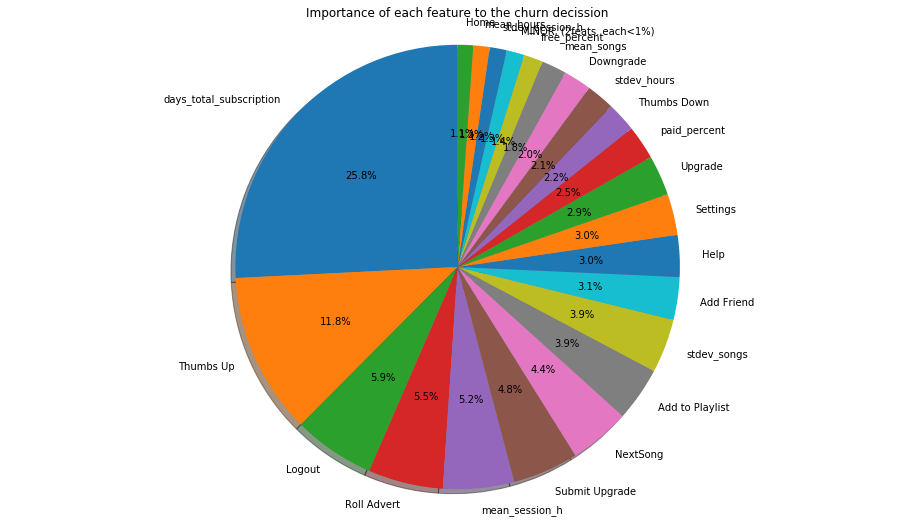

In [43]:
draw_features_importance(m, features_labels, threshold=1)

### Decision Tree

In [44]:
# The Decision Tree Classifier model

model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .build()

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')

Fitting in progress... Done in 24.165826320648193 seconds

Saving the model as DecisionTreeClassifier.model... Done in 0.657585859298706 seconds


In [46]:
# to load the model from saved location
m = mlm.load('DecisionTreeClassifier.model')

In [47]:
get_classifier_metrics(m, train, test)

,Train,Test
Precision,0.871795,0.800000
Recall,0.435897,0.190476
F-Score,0.581197,0.307692


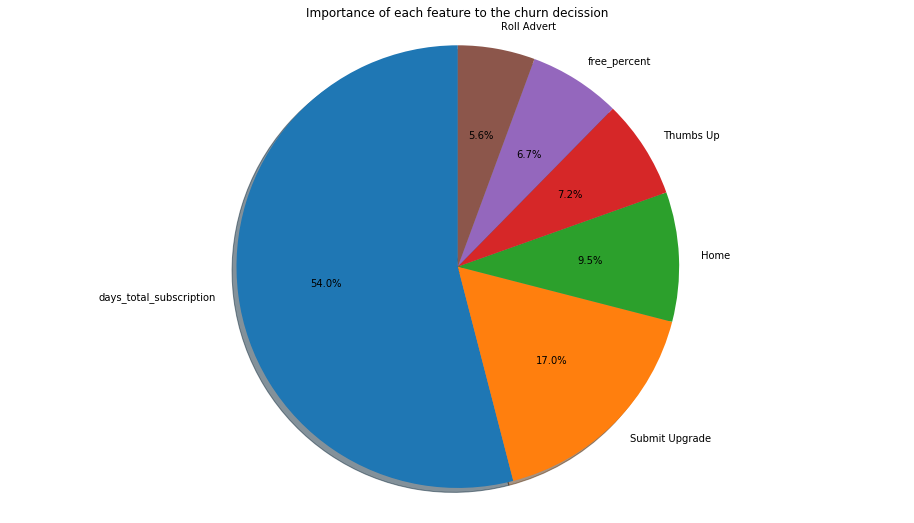

In [48]:
draw_features_importance(m, features_labels, threshold=1)

### Gradient-Boosted Tree

In [49]:
# The Gradient-Boosted Trees (GBTs) model
model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.maxIter ,[20, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

Fitting in progress... Done in 323.0090799331665 seconds

Saving the model as GradientBoostedTrees.model... Done in 0.9484872817993164 seconds


In [50]:
m = mlm.load('GradientBoostedTrees.model')

In [51]:
display(get_classifier_metrics(m, train, test))

,Train,Test
Precision,0.891304,0.444444
Recall,0.525641,0.190476
F-Score,0.661290,0.266667


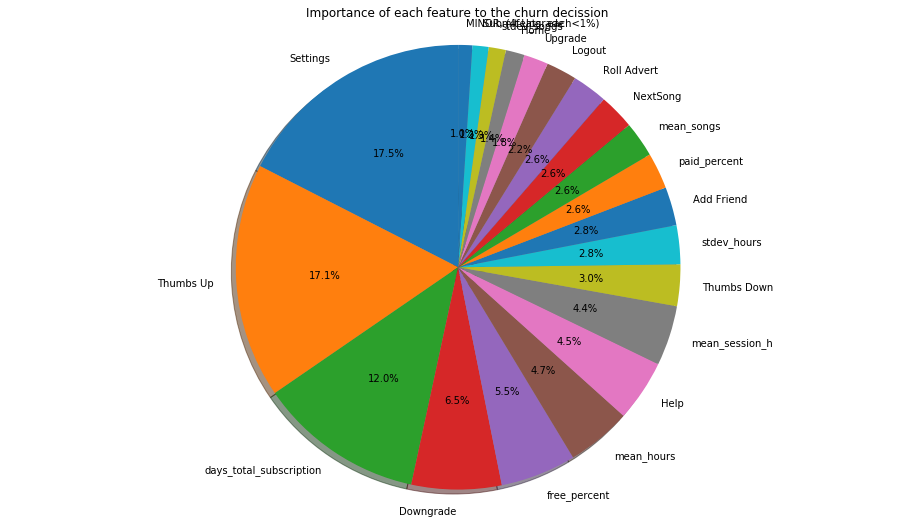

In [52]:
draw_features_importance(m, features_labels, threshold=1)

# 5. Conclusion

It seems machine learning algorithms can predict users who will end up unsubscribing. Among the algorithms tested, the decision tree classifier did the best in all the evaluation metrics (Accuracy, precision, Recall, and F-Score). It seems days_total_subscription has high feature importance which is understandable.

# 6. Next Step
The work presented shows how features can be engineered from event logs to create data that can be used in the machine learning model. Additional approaches to the problem could be investigated, these are some possibilities:
Create time-based features: features for the last n days.
Rolling average features: create window operations back in time for each event and labels of those windows based on churn events forward in time.
Redefine the problem as a regression problem by defining churn as the number of days until cancellation.